In [107]:
import pandas as pd
import altair as alt
import umap
%matplotlib inline
alt.renderers.enable('notebook')
import imp
esp_ddi_util = imp.load_source('esp_ddi_util', 'esp_ddi_util.py')

In [23]:
!conda list | grep umap
!conda list | grep scikit-learn
!conda list | grep altair
!conda list | grep vega
!conda list | grep pandas

umap-learn                0.3.9                    py37_0    conda-forge
scikit-learn              0.19.1           py37hedc7406_0  
altair                    3.1.0                    py37_0    conda-forge
vega                      2.4.0                    py37_0    conda-forge
pandas                    0.24.2           py37he6710b0_0  


# Load data
For this notebook we will need the following data:
* **Training and test data**. To make our results directly comparable, we use the train/test splits produced by our Decagon run.
* **Mappings of drug and side effect IDs to their names**. Using names instead of IDs makes interpretation of the trained representations more convenient. While the side effect names come with the _bio-decagon_ data sets, the drug IDs had to be resolved separately using [version 2 of the STITCH ID database](http://stitch2.embl.de/). For convenience, files with the mappings are included in the repository. 

## Load names

In [280]:
drug_names_df = pd.read_csv("drug_names.csv", header=None)
drug_names_df.columns = ["drug", "drug_name"]
# rename drugs to conform to ESP subject/object convention
drug_names_df.drug_name = drug_names_df.drug_name.apply(
    lambda x: x.replace(" ", "_").lower())
drug_names_df.head()

,drug,drug_name
0,CID000000085,carnitine
1,CID000000119,gaba
2,CID000000143,leucovorin
3,CID000000158,pge2
4,CID000000159,prostacyclin


In [281]:
# create dictionary for later drug lookup
drug_names = drug_names_df.set_index('drug').to_dict()['drug_name']

side_effect_names_df = pd.read_csv(
    "side_effect_names.tsv", sep='\t', header=None)
side_effect_names_df.columns = ["side_effect", "side_effect_name"]

# rename side effects to conform to ESP predicate convention
side_effect_names_df.side_effect_name = side_effect_names_df.side_effect_name.apply(
    lambda x: x.replace(" ", "_").upper())
side_effect_names_df.head()

,side_effect,side_effect_name
0,C0151714,HYPERMAGNESEMIA
1,C0035344,RETINOPATHY_OF_PREMATURITY
2,C0004144,ATELECTASIS
3,C0002063,ALKALOSIS
4,C0004604,BACK_ACHE


In [282]:
side_effect_names = side_effect_names_df.set_index(
    "side_effect").to_dict()["side_effect_name"]

# examples
drug_names['CID000000853'], side_effect_names['C0035344']

('thyroxine', 'RETINOPATHY_OF_PREMATURITY')

## Load splits
The provided data sets were output by our own version of the Decagon code, available in the companion repository at https://github.com/hannahburkhardt/decagon. They are available for download from our zenodo repository at [TBD]. Predictions produced by this Decagon run are also available there.

The zenodo repository also contains a set of trained vector binaries produced by ESP, as well as a jar of the version of the semanticvector library used in this project. You may also download the source code from https://github.com/semanticvectors/semanticvectors and build semanticvectors yourself.

In [321]:
!cd ..; wget https://sandbox.zenodo.org/record/326362/files/esp_ddi_zenodo.tar.gz
!cd ..; tar -xzvf esp_ddi_zenodo.tar.gz

--2019-07-22 10:56:01--  https://sandbox.zenodo.org/record/326362/files/esp_ddi_zenodo.tar.gz
Resolving sandbox.zenodo.org (sandbox.zenodo.org)... 188.184.135.96
Connecting to sandbox.zenodo.org (sandbox.zenodo.org)|188.184.135.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 188624279 (180M) [application/octet-stream]
Saving to: ‘esp_ddi_zenodo.tar.gz.1’

esp_ddi_zenodo.tar. 100%[===================>] 179.89M  17.7MB/s    in 11s     

2019-07-22 10:56:13 (15.9 MB/s) - ‘esp_ddi_zenodo.tar.gz.1’ saved [188624279/188624279]

zenodo/
zenodo/semanticvectors_16k_8cycles.bin
zenodo/decagon_split_train_drug_protein.tsv
zenodo/decagon_split_val_ddi_pos.tsv
zenodo/decagon_split_val_ddi_neg.tsv
zenodo/decagon_split_train_ddi.tsv
zenodo/semanticvectors-5.9.jar
zenodo/predicatevectors_16k_8cycles.bin
zenodo/decagon_split_test_ddi_pos.tsv
zenodo/decagon_scores_8_epochs.txt
zenodo/decagon_split_train_ppi.tsv
zenodo/decagon_split_test_ddi_neg.tsv
zenodo/elementalvectors_16

In [322]:
file_location = "../zenodo/"

# Training data
train_ddi = pd.read_csv(
    file_location + 'decagon_split_train_ddi.tsv', sep="\t", header=None)
train_ppi = pd.read_csv(
    file_location + 'decagon_split_train_ppi.tsv', sep="\t", header=None)
train_drug_protein = pd.read_csv(
    file_location + 'decagon_split_train_drug_protein.tsv', sep="\t", header=None)

# Test data
test_ddi_pos = pd.read_csv(
    file_location + 'decagon_split_test_ddi_pos.tsv', sep="\t", header=None)
test_ddi_neg = pd.read_csv(
    file_location + 'decagon_split_test_ddi_neg.tsv', sep="\t", header=None)

# Validation data
val_ddi_pos = pd.read_csv(
    file_location + 'decagon_split_val_ddi_pos.tsv', sep="\t", header=None)

val_ddi_neg = pd.read_csv(
    file_location + 'decagon_split_val_ddi_neg.tsv', sep="\t", header=None)


In [285]:
resolve_drug_id = lambda drug_id: drug_names[drug_id] if drug_id in drug_names.keys() else drug_id
resolve_side_effect_id = lambda side_effect_id: side_effect_names[side_effect_id[:-2]]+"-2" if side_effect_id[-2:]=="-2" else side_effect_names[side_effect_id]

def resolve_names_ddi_df(df):
    df['subject'] = df[0].apply(resolve_drug_id)
    df['predicate'] = df[1].apply(resolve_side_effect_id)
    df['object'] = df[2].apply(resolve_drug_id)

def resolve_names_drug_protein_df(df):
    df['subject'] = df[0].apply(resolve_drug_id)
    df['predicate'] = df[1]
    df['object'] = df[2]

def resolve_names_protein_protein_df(df):
    df['subject'] = df[0]
    df['predicate'] = df[1]
    df['object'] = df[2]

## Prep data

### Resolve IDs to names
For readability, resolve drug and side effect IDs to names. No need to resolve protein IDs.

In [286]:
print(len(train_ddi))
train_ddi.sample(5)

7323790


,0,1,2
5729406,CID000005073,C0038454-2,CID000002732
856664,CID000000853,C0012833,CID000003440
1295403,CID000002978,C0035455,CID000003348
2381377,CID000003062,C0004238,CID000003310
670282,CID000002756,C0012569,CID000003003


In [287]:
train_drug_protein.sample(5)

,0,1,2
7862,CID005329102,TARGETS,7006
14003,CID000004140,TARGETS,10887
6485,CID000003158,TARGETS,3362
2927,CID000000271,TARGETS,4651
7211,CID000036811,TARGETS,4158


In [288]:
train_ppi.sample(5)

,0,1,2
507845,83858,INTERACTS_WITH,27043
2147021,57578,INTERACTS_WITH-2,259232
111531,5431,INTERACTS_WITH,5929
1492915,10135,INTERACTS_WITH-2,11338
1751103,23523,INTERACTS_WITH-2,5578


In [289]:
for df in [train_ddi, test_ddi_pos, test_ddi_neg, val_ddi_pos, val_ddi_neg]:
    resolve_names_ddi_df(df)

resolve_names_drug_protein_df(train_drug_protein)

resolve_names_protein_protein_df(train_ppi)

In [290]:
train_ddi.sample(5)

,0,1,2,subject,predicate,object
775454,CID000002267,C0043117,CID000003746,azelastine,IDIOPATHIC_THROMBOCYTOPENIC_PURPURA,ipratropium_bromide
4130996,CID000004594,C0001339-2,CID000002678,omeprazole,ACUTE_PANCREATITIS-2,cetirizine
323850,CID000003403,C0020040,CID000005035,fluvastatin,HOT_FLASH,raloxifene
927200,CID000004173,C0004096,CID000004900,metronidazole,ASTHMA,prednisone
2426998,CID000002554,C0006325,CID000002666,carbamazepine,BRUXISM,cephalexin


In [291]:
train_ppi.tail()

,0,1,2,subject,predicate,object
2289955,10488,INTERACTS_WITH-2,10990,10488,INTERACTS_WITH-2,10990
2289956,26580,INTERACTS_WITH-2,285733,26580,INTERACTS_WITH-2,285733
2289957,6700,INTERACTS_WITH-2,6701,6700,INTERACTS_WITH-2,6701
2289958,3163,INTERACTS_WITH-2,54842,3163,INTERACTS_WITH-2,54842
2289959,720,INTERACTS_WITH-2,440955,720,INTERACTS_WITH-2,440955


In [292]:
train_drug_protein.head()

,0,1,2,subject,predicate,object
0,CID000003345,TARGETS,3757,fentanyl,TARGETS,3757
1,CID000003345,TARGETS,2850,fentanyl,TARGETS,2850
2,CID000003345,TARGETS,4157,fentanyl,TARGETS,4157
3,CID000003345,TARGETS,1902,fentanyl,TARGETS,1902
4,CID000003345,TARGETS,2925,fentanyl,TARGETS,2925


### Create files with training and test data
ESP accepts input files with tab separated subject-predicate-object triples. Here, we write the training data to the _outputs_ directory in this format.

In [37]:
%%bash
mkdir -p ../outputs/

In [293]:
file_location = "../outputs/" 

# All three types of data are used for training
train_ddi.append(train_ppi).append(train_drug_protein)[
    ['subject', 'predicate', 'object']].to_csv(path_or_buf=file_location+"training_examples.tsv", sep='\t', index=False, header=False)

# Use only the ddi data for testing sets
all_test_pos = test_ddi_pos[['subject', 'predicate', 'object']]
# remove reversed side effects for testing
all_test_pos = all_test_pos[~all_test_pos.predicate.str.contains("-2")]
all_test_pos.to_csv(path_or_buf=file_location +
                    "positive_examples.tsv", sep='\t', index=False, header=False)

all_test_neg = test_ddi_neg[['subject', 'predicate', 'object']]
# remove reversed side effects for testing
all_test_neg = all_test_neg[~all_test_neg.predicate.str.contains("-2")]
all_test_neg.to_csv(path_or_buf=file_location +
                    "negative_examples.tsv", sep='\t', index=False, header=False)

In [294]:
len(all_test_pos.predicate.unique())

963

### Create files with evaluation strings
For testing, we determine the similarity between the representatation of the drug pair, `S(drug1)*E(drug2)`, and the representation of the side effect, `P(side effect)`. Semanticvectors accepts a file with a list of these, one per line.

In [295]:
make_string = lambda row: "S({})*E({})|P({})".format(row.subject, row.object, row.predicate)

positive_test_strings = all_test_pos.apply(make_string, axis=1)
positive_test_strings.to_csv(
    path=file_location+"positive_examples.csv", index=False, header=False)

negative_test_strings = all_test_neg.apply(make_string, axis=1)
negative_test_strings.to_csv(
    path=file_location+"negative_examples.csv", index=False, header=False)

/home/haalbu/anaconda3/envs/jupyter_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'path' will be renamed to 'path_or_buf'.
  """
/home/haalbu/anaconda3/envs/jupyter_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'path' will be renamed to 'path_or_buf'.
  if __name__ == '__main__':


# Train the model
Create the index and train the ESP model with 1024 dimensions for 4 training cycles. This will take a while (depending on hardware, about 1 hour).
The paper used 16,000 dimensions with 8 cycles. This would take about 3.5 hours.

In [21]:
# Use 2> /dev/null to silence stderr
%%bash 
cd ../outputs

java -cp ../zenodo/semanticvectors-5.9.jar pitt.search.lucene.LuceneIndexFromTriples training_examples.tsv 2> /dev/null

java -cp ../zenodo/semanticvectors-5.9.jar pitt.search.semanticvectors.ESP -luceneindexpath predication_index -vectortype binary -dimension 1024 -trainingcycles 4 -mutablepredicatevectors -samplingthreshold .00001 -numthreads 60 2> /dev/null

# Evaluation

## Make predictions on test set
Next, we make predictions for each triple in the test set by determining the similarity of the bound representations for the 2 drugs with the representation for the side effect.

This will take a couple of minutes depending on vector dimensionality.

In [46]:
%%bash
cd ../outputs

# evaluate positive test examples
java -cp ../zenodo/semanticvectors-5.9.jar pitt.search.semanticvectors.CompareTermsBatch -elementalvectorfile elementalvectors.bin -semanticvectorfile semanticvectors.bin -elementalpredicatevectorfile predicatevectors.bin -matchcase -searchtype boundproduct < positive_examples.csv > positive_examples_scores.txt 2> /dev/null

# evaluate negative test examples (generated)
java -cp ../zenodo/semanticvectors-5.9.jar pitt.search.semanticvectors.CompareTermsBatch -elementalvectorfile elementalvectors.bin -semanticvectorfile semanticvectors.bin -elementalpredicatevectorfile predicatevectors.bin -matchcase -searchtype boundproduct < negative_examples.csv > negative_examples_scores.txt 2> /dev/null

# Alternatively, use the pre-trained vectors:
# java -cp ../zenodo/semanticvectors-5.9.jar pitt.search.semanticvectors.CompareTermsBatch -elementalvectorfile ../zenodo/elementalvectors_16k_8cycles.bin -semanticvectorfile ../zenodo/semanticvectors_16k_8cycles.bin -elementalpredicatevectorfile ../zenodo/predicatevectors_16k_8cycles.bin -matchcase -searchtype boundproduct < positive_examples.csv > positive_examples_scores.txt 2> /dev/null
# java -cp ../zenodo/semanticvectors-5.9.jar pitt.search.semanticvectors.CompareTermsBatch -elementalvectorfile ../zenodo/elementalvectors_16k_8cycles.bin -semanticvectorfile ../zenodo/semanticvectors_16k_8cycles.bin -elementalpredicatevectorfile ../zenodo/predicatevectors_16k_8cycles.bin -matchcase -searchtype boundproduct < negative_examples.csv > negative_examples_scores.txt 2> /dev/null

Process is terminated.


## Performance
We evaluate performance of our model by determining the AUROC, AUPRC, and AP@50 for each individual side effect. Performance is then reported as the average performance across the 963 side effects. This allows a direct comparison to the Decagon model's performance, which is reported in this way. Note that this approach causes the average AUROC to be higher than the overall AUROC if some high-performance side effects have few examples or low-performance side effects have many examples.

Positive results mean score: 0.352
Negative results mean score: 0.136
Overall AUROC: 0.889
Overall AUPRC: 0.854
Overall AP50: 0.949

Average performance over 963 side effects:
       median   mean    std    sem    min    max
auroc   0.903  0.903  0.023  0.001  0.841  0.977
auprc   0.873  0.875  0.034  0.001  0.779  0.976
ap50    0.873  0.865  0.073  0.002  0.550  1.000


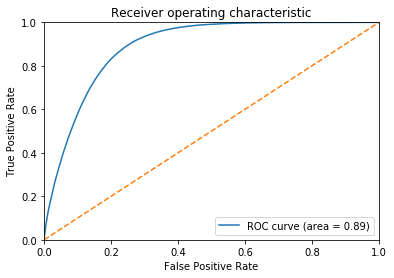

In [296]:
esp_aurocs_by_se = esp_ddi_util.get_aurocs_by_side_effect_files(file_location="../outputs/")

In [297]:
esp_aurocs_by_se.head()

,auroc,auprc,ap50,negative_examples,positive_examples
predicate_name,,,,,
ABDOMINAL_DISTENSION,0.875768,0.833755,0.896605,1236,1236
ABDOMINAL_HERNIA,0.939464,0.936977,1.000000,275,275
ABDOMINAL_PAIN,0.874220,0.833877,0.829504,2141,2141
ABDOMINAL_PAIN_UPPER,0.877330,0.836777,0.879883,1316,1316
ABNORMAL_CERVICAL_SMEAR,0.899219,0.860803,0.744635,66,66


Best and worst performing side effects for each measure:

In [298]:
for c in ['auroc', 'auprc', 'ap50']:
    print(c)
    print('min:', esp_aurocs_by_se[c].idxmin(), round(esp_aurocs_by_se[c].min(
    ), 3), 'max:', esp_aurocs_by_se[c].idxmax(), round(esp_aurocs_by_se[c].max(), 3))
    print()

auroc
min: PATENT_DUCTUS_ARTERIOSIS 0.841 max: MUMPS 0.977

auprc
min: CAESAREAN_SECTION 0.779 max: MUMPS 0.976

ap50
min: CAROTID_ARTERY_STENOSIS 0.55 max: ABDOMINAL_HERNIA 1.0



### Performance distribution
Distribution of AUROCs: Does the model perform either well or poorly for most side effects, or are they normally distributed?

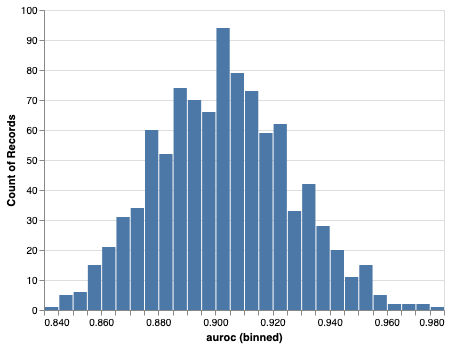

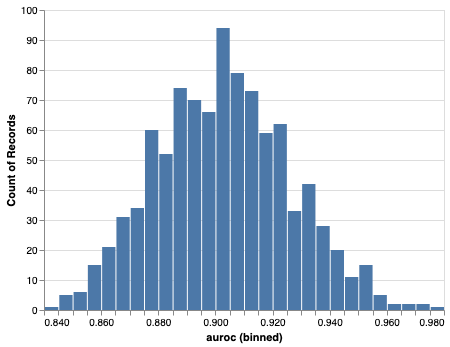

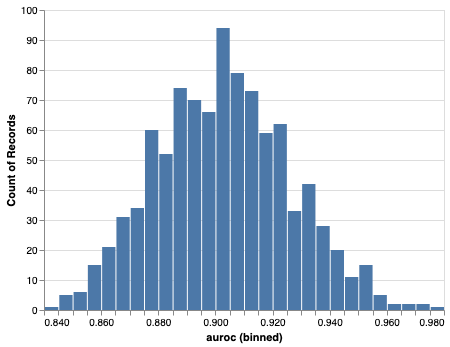

In [299]:
alt.Chart(esp_aurocs_by_se).mark_bar().encode(
    x=alt.X(
        'auroc', 
        bin=alt.Bin(maxbins=50)
    ), 
    y='count()', 
    tooltip=[
        alt.Tooltip('count()')
    ]
)

### Performance by side effect frequency
Does performance differ significantly depending on the number of examples we have for each side effect? 

This chart shows that performance is, on average, higher if there are fewer examples. This may be the case for a number of reasons, including that commonly reported side effects, such as nausea, may have a more noisy signal precisely because they are generally common and thus may not always be due to the particular combination of drugs. On the other hand, the model may be overfitting rare side effects, such as mumps, and performance may thus be inflated for these side effects.

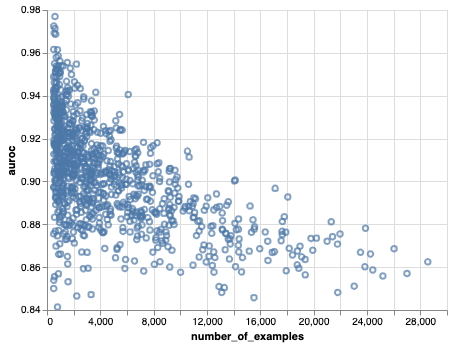

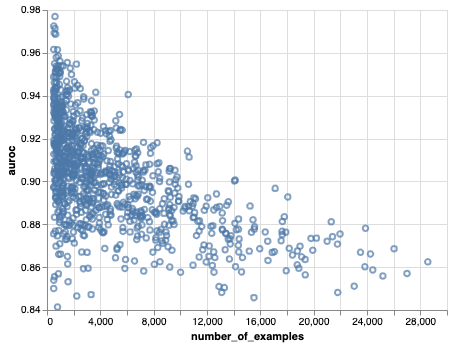

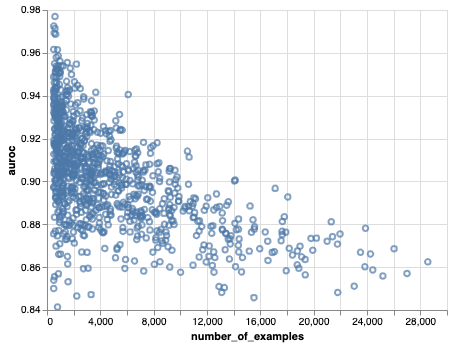

In [300]:
# the positive testing examples constitute 10% of the total number of samples in the dataset
alt.Chart(
    esp_aurocs_by_se.reset_index()
).mark_point().encode(
    alt.Y(
        'auroc',
        scale=alt.Scale(zero=False)
    ),
    x='number_of_examples:Q',
    tooltip=['predicate_name', 'number_of_examples:Q']
).transform_calculate(
    number_of_examples=alt.datum.positive_examples*10
)

### Score distribution by label
How are scores for positive and negatie examples distributed? Again, note that the similarity scores do not range from 0 to 1 for ESP, as they do for the Decagon predictions.

In [301]:
file_location='../outputs/'
pos_scores = pd.read_csv(file_location + "positive_examples_scores.txt",
                         header=None).rename(columns={0: 'score'})
pos_scores['truth'] = 1
neg_scores = pd.read_csv(file_location + "negative_examples_scores.txt",
                         header=None).rename(columns={0: 'score'})
neg_scores['truth'] = 0
scores = pos_scores.append(neg_scores)
scores.head()

,score,truth
0,0.209250,1
1,0.239750,1
2,0.196000,1
3,0.399125,1
4,0.027500,1


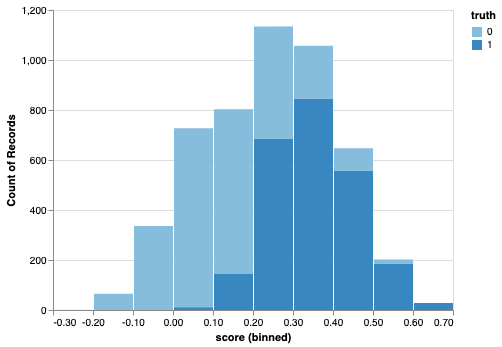

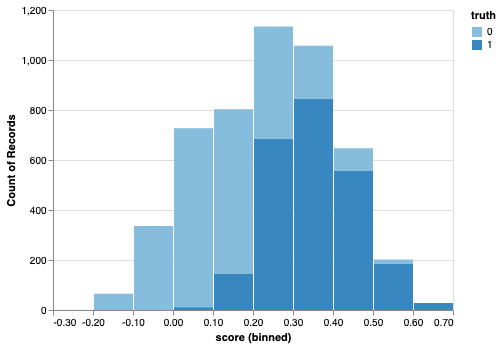

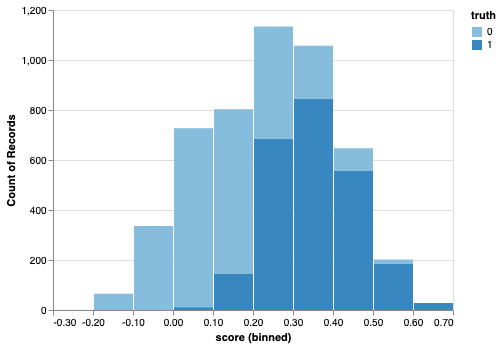

In [302]:
alt.Chart(scores.sample(5000)).mark_bar().encode(
    x=alt.X("score", bin=True), 
    y='count()', 
    color='truth:O'
)

## Dimensionality analysis

How low can we go in dimensionality and still preserve acceptable performance?

The below bash script will translate the produced binary vector files into text files, truncate them to the given dimensionalities, turn them back into binary vector files, and evaluate the testing examples with the new vector files. This may take a while (depending on the number of dimensions, at least 3 min).

In [64]:
%%bash
cd ../outputs

# translate vectors from binary format into text format
for vectors in elementalvectors semanticvectors predicatevectors
do
    java -cp ../zenodo/semanticvectors-5.9.jar pitt.search.semanticvectors.VectorStoreTranslater -lucenetotext ${vectors}.bin ${vectors}.txt
done

# use appropriate list of dimensions, e.g. 8000 4096 2048 1024 512 256 128 64 
for dimensions in 16000 8000 4096 2048 1024 512 256 128 64 
do
    echo Truncate and evaluate for ${dimensions} dimensions
    SECONDS=0

    # ------ truncate
    for vectors in elementalvectors semanticvectors predicatevectors
    do
        echo "-vectortype BINARY -dimension ${dimensions}" > ${vectors}_truncated.txt
        # take all lines starting at line 2
        tail -n +2 ${vectors}.txt | cut -f 2 -d "|" | cut -c 1-${dimensions} > tmp.txt
        tail -n +2 ${vectors}.txt | cut -f 1 -d "|" > tmp_names.txt
        paste -d "|" tmp_names.txt tmp.txt >> ${vectors}_truncated.txt
        
        # translate the text file back to binary vector format
        java -cp ../zenodo/semanticvectors-5.9.jar pitt.search.semanticvectors.VectorStoreTranslater -texttolucene ${vectors}_truncated.txt ${vectors}_${dimensions}.bin
        
        # remove the txt and temporary files
        rm ${vectors}_truncated.txt
        rm tmp.txt
        rm tmp_names.txt
    done

    # ------ evaluate
    for i in positive negative 
    do
        java -cp ../zenodo/semanticvectors-5.9.jar pitt.search.semanticvectors.CompareTermsBatch -elementalvectorfile elementalvectors_${dimensions}.bin -semanticvectorfile semanticvectors_${dimensions}.bin -elementalpredicatevectorfile predicatevectors_${dimensions}.bin -matchcase -searchtype boundproduct < ${i}_examples.csv > ${i}_examples_scores_${dimensions}.txt
    done

    duration=$SECONDS
    echo "$(($duration / 60)) minutes and $(($duration % 60)) seconds elapsed."
done

for vectors in elementalvectors semanticvectors predicatevectors 
do
    rm ${vectors}.txt
done

Truncate and evaluate for 16000 dimensions
6 minutes and 46 seconds elapsed.
Truncate and evaluate for 8000 dimensions
3 minutes and 36 seconds elapsed.
Truncate and evaluate for 4096 dimensions
2 minutes and 3 seconds elapsed.
Truncate and evaluate for 2048 dimensions
1 minutes and 18 seconds elapsed.
Truncate and evaluate for 1024 dimensions
0 minutes and 55 seconds elapsed.
Truncate and evaluate for 512 dimensions
0 minutes and 49 seconds elapsed.
Truncate and evaluate for 256 dimensions
0 minutes and 39 seconds elapsed.
Truncate and evaluate for 128 dimensions
0 minutes and 28 seconds elapsed.
Truncate and evaluate for 64 dimensions
0 minutes and 26 seconds elapsed.


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [66]:
file_location = "../outputs/"
metrics = esp_ddi_util.truncation_analysis(
    file_location=file_location, truncation_dimensions=[16000, 8000, 4096, 2048, 1024, 512, 256, 128, 64], plot=False)
metrics

,mean_auprc,mean_auroc,mean_ap50,auroc_min,auroc_max,auprc_min,auprc_max,ap50_min,ap50_max
16000,0.874691,0.902755,0.865115,0.841372,0.976944,0.779075,0.975970,0.549648,1.0
8000,0.875395,0.903338,0.865429,0.841852,0.976667,0.781736,0.975748,0.580763,1.0
4096,0.874001,0.902291,0.863477,0.829755,0.976389,0.780092,0.974922,0.565470,1.0
2048,0.871938,0.899710,0.864765,0.835123,0.976528,0.774456,0.976239,0.572651,1.0
1024,0.864960,0.894163,0.858124,0.828393,0.975417,0.765336,0.973804,0.587940,1.0
512,0.861709,0.891629,0.859191,0.820782,0.974722,0.755851,0.972962,0.602089,1.0
256,0.851453,0.882465,0.851495,0.799446,0.972318,0.746115,0.970941,0.572826,1.0
128,0.830642,0.858364,0.846914,0.759723,0.954633,0.721208,0.950408,0.568918,1.0
64,0.793189,0.823440,0.828605,0.722481,0.929835,0.677693,0.940448,0.536297,1.0


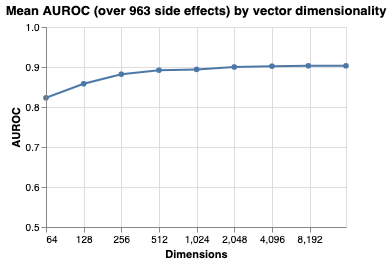

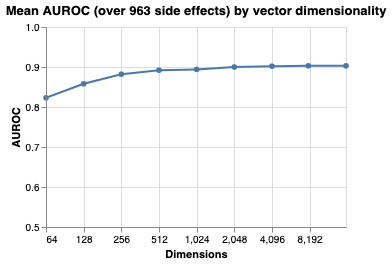

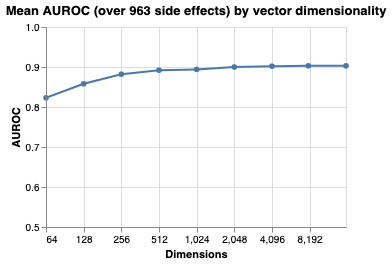

In [103]:
alt.Chart(
    metrics.reset_index().round(3),
    title='Mean AUROC (over 963 side effects) by vector dimensionality'
).mark_line(
    point=True
).encode(
    alt.X(
        'index:Q',
        title='Dimensions',
        scale=alt.Scale(type='log', base=2)
    ),
    alt.Y(
        'mean_auroc',
        title="AUROC",
        scale=alt.Scale(domain=[0.5, 1])
    ),
    tooltip=['mean_auroc', 'mean_auprc', 'mean_ap50']
).properties(width=300,height=200)

## Umap

In [68]:
%%bash
mkdir -p ../bio-decagon
cd ../bio-decagon/

wget http://snap.stanford.edu/decagon/bio-decagon-effectcategories.tar.gz
tar -zxvf bio-decagon-effectcategories.tar.gz

./._bio-decagon-effectcategories.csv
bio-decagon-effectcategories.csv


--2019-07-21 00:33:05--  http://snap.stanford.edu/decagon/bio-decagon-effectcategories.tar.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7742 (7.6K) [application/x-gzip]
Saving to: ‘bio-decagon-effectcategories.tar.gz.3’

     0K .......                                               100%  720M=0s

2019-07-21 00:33:05 (720 MB/s) - ‘bio-decagon-effectcategories.tar.gz.3’ saved [7742/7742]



In [69]:
# Load side effect classes
file_location = "../bio-decagon/"
se_classes = pd.read_csv(file_location + "bio-decagon-effectcategories.csv")
se_classes.columns = ['side_effect', 'side_effect_name', 'disease_class']
se_classes.side_effect_name = se_classes.side_effect_name.apply(
    lambda x: x.replace(" ", "_").upper())
print(len(se_classes))
se_classes.head()

561


,side_effect,side_effect_name,disease_class
0,C0017152,GASTRIC_INFLAMMATION,gastrointestinal system disease
1,C0027858,NEUROMA,benign neoplasm
2,C0041466,TYPHOID,bacterial infectious disease
3,C0032807,POST_THROMBOTIC_SYNDROME,cardiovascular system disease
4,C0033860,PSORIASIS,integumentary system disease


In [70]:
# eliminate redundancy
se_classes.disease_class = se_classes.disease_class.apply(lambda x: 'hematopoietic system disease' if x=='hematopoietic system diseases' else x)

In [71]:
se_classes = se_classes.set_index('side_effect_name').disease_class.to_dict()

In [72]:
%%bash
cd ../outputs
for vectors in elementalvectors semanticvectors predicatevectors
do
    java -cp ../zenodo/semanticvectors-5.9.jar pitt.search.semanticvectors.VectorStoreTranslater -lucenetotext ${vectors}.bin ${vectors}.txt
done

Setting dimension of target config to: 16000
Setting vectortype of target config to: BINARY
Writing term vectors to elementalvectors.txt
About to write 20004 vectors of dimension 16000 to text file: elementalvectors.txt ... finished writing vectors.
Setting dimension of target config to: 16000
Setting vectortype of target config to: BINARY
Writing term vectors to semanticvectors.txt
About to write 20004 vectors of dimension 16000 to text file: semanticvectors.txt ... finished writing vectors.
Setting dimension of target config to: 16000
Setting vectortype of target config to: BINARY
Writing term vectors to predicatevectors.txt
About to write 3860 vectors of dimension 16000 to text file: predicatevectors.txt ... finished writing vectors.


In [73]:
file_location = '../outputs/'
predicate_vectors = pd.read_csv(file_location+"/predicatevectors.txt", sep="|")
predicate_vectors.head()
predicate_vectors.columns = ['bits']
len(predicate_vectors)

3860

In [74]:
predicate_vectors = predicate_vectors.drop(predicate_vectors.index[predicate_vectors.index.str.endswith(
    "-2") | predicate_vectors.index.str.endswith("-INV")])
print(len(predicate_vectors))
predicate_vectors.head()

965


,bits
PANCREATITIS_RELAPSING,0010001000101101101101100100101111000101111100...
VESTIBULAR_DISORDER,0000001001001101101100100100100111100100111100...
HAIR_DISEASE,0010001100100101001010100100100101100100011100...
CLOTTING,0000001001101101101100000100100111100100111100...
INFLAMMATORY_BOWEL_DISEASE,0010001000100101100000000100100101000000111100...


In [75]:
bit_df = predicate_vectors.bits.apply(lambda x: pd.Series(list(x)))
bit_matrix = bit_df.values
bit_df.head()

,0,1,2,3,4,5,6,7,8,9,...,15990,15991,15992,15993,15994,15995,15996,15997,15998,15999
PANCREATITIS_RELAPSING,0,0,1,0,0,0,1,0,0,0,...,1,1,1,0,0,1,1,0,0,0
VESTIBULAR_DISORDER,0,0,0,0,0,0,1,0,0,1,...,0,1,1,0,0,0,1,0,0,1
HAIR_DISEASE,0,0,1,0,0,0,1,1,0,0,...,0,0,1,0,0,1,0,0,0,1
CLOTTING,0,0,0,0,0,0,1,0,0,1,...,0,0,1,0,0,1,0,0,0,0
INFLAMMATORY_BOWEL_DISEASE,0,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [76]:
targets = pd.DataFrame(bit_df.index.values)
targets['target'] = targets[0].apply(lambda x: se_classes[x] if x in se_classes else 'other')
targets = targets.set_index(0)
targets.head()

,target
0,
PANCREATITIS_RELAPSING,other
VESTIBULAR_DISORDER,nervous system disease
HAIR_DISEASE,integumentary system disease
CLOTTING,hematopoietic system disease
INFLAMMATORY_BOWEL_DISEASE,gastrointestinal system disease


In [77]:
most_frequent_except_other = targets.target.value_counts().sort_values(ascending=False).reset_index().rename(columns={'target':'count', 'index':'class_name'}).class_name.tolist()[1:]
most_frequent_except_other

['nervous system disease',
 'cardiovascular system disease',
 'gastrointestinal system disease',
 'musculoskeletal system disease',
 'integumentary system disease',
 'respiratory system disease',
 'cancer',
 'urinary system disease',
 'hematopoietic system disease',
 'acquired metabolic disease',
 'viral infectious disease',
 'endocrine system disease',
 'reproductive system disease',
 'immune system disease',
 'fungal infectious disease',
 'benign neoplasm',
 'cognitive disorder',
 'inherited metabolic disorder',
 'bacterial infectious disease',
 'developmental disorder of mental health',
 'thoracic disease',
 'sleep disorder',
 'somatoform disorder',
 'pre-malignant neoplasm',
 'irritable bowel syndrome',
 'personality disorder',
 'psoriatic arthritis',
 'substance-related disorder',
 'sexual disorder']

In [78]:
import umap, matplotlib.pyplot as plt, numpy as np
points = umap.UMAP(random_state=42).fit_transform(bit_df)

# Optionally t-SNE:
# from sklearn.manifold import TSNE
# points=TSNE(random_state=42).fit_transform(bit_df)

len(points)

/home/haalbu/anaconda3/envs/jupyter_env/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/haalbu/anaconda3/envs/jupyter_env/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../anaconda3/envs/jupyter_env/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/haalbu/anaconda3/envs/jupyter_env/lib/python3.7/site-packages/numba/compiler.py:725: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=

965

In [79]:
points_df = pd.DataFrame(points)
points_df['group'] = targets.reset_index().target
points_df['side_effect'] = targets.reset_index()[0]
points_df.columns=["x","y",'group','side_effect']
points_df.head()

,x,y,group,side_effect
0,-0.361965,-1.927125,other,PANCREATITIS_RELAPSING
1,1.886441,0.560535,nervous system disease,VESTIBULAR_DISORDER
2,3.146714,-0.152149,integumentary system disease,HAIR_DISEASE
3,5.107449,-3.731180,hematopoietic system disease,CLOTTING
4,0.009163,0.270305,gastrointestinal system disease,INFLAMMATORY_BOWEL_DISEASE


In [80]:
points_df.group.unique()

array(['other', 'nervous system disease', 'integumentary system disease',
       'hematopoietic system disease', 'gastrointestinal system disease',
       'somatoform disorder', 'respiratory system disease',
       'cardiovascular system disease', 'musculoskeletal system disease',
       'bacterial infectious disease', 'fungal infectious disease',
       'substance-related disorder', 'acquired metabolic disease',
       'thoracic disease', 'urinary system disease', 'cancer',
       'endocrine system disease', 'irritable bowel syndrome',
       'cognitive disorder', 'viral infectious disease',
       'reproductive system disease', 'immune system disease',
       'benign neoplasm', 'inherited metabolic disorder',
       'developmental disorder of mental health',
       'pre-malignant neoplasm', 'sexual disorder', 'sleep disorder',
       'personality disorder', 'psoriatic arthritis'], dtype=object)

### Most frequent

In [81]:
groups = most_frequent_except_other[:6]
groups

['nervous system disease',
 'cardiovascular system disease',
 'gastrointestinal system disease',
 'musculoskeletal system disease',
 'integumentary system disease',
 'respiratory system disease']

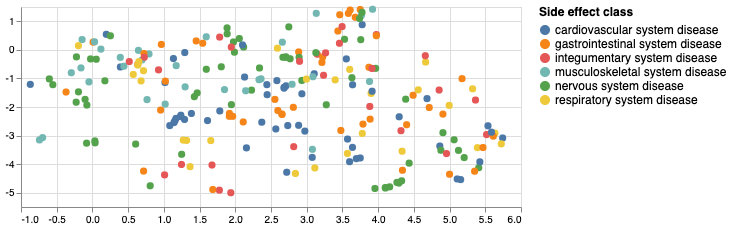

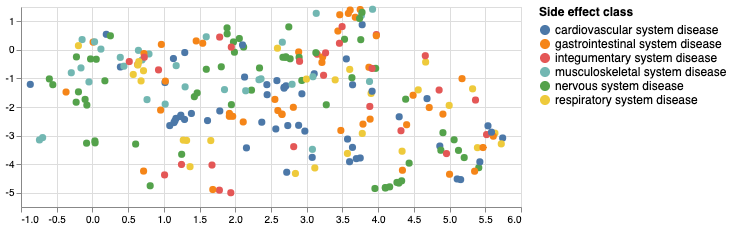

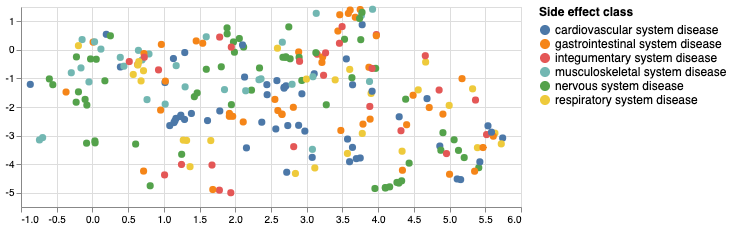

In [82]:
alt.Chart(data=points_df).mark_circle(size=50, opacity=1).encode(
    alt.X("x:Q", title=""),
    alt.Y("y:Q", title=""),
    alt.Color('group:N', title="Side effect class", scale=alt.Scale()),
    alt.Tooltip('side_effect:N')
).transform_filter(
    alt.FieldOneOfPredicate(field='group', oneOf=groups)
).properties(width=500, height=200).configure_legend(labelFontSize=12,labelLimit=250,titleFontSize=12)

### Random

In [83]:
groups = pd.DataFrame(most_frequent_except_other).sample(8, random_state=42)[0].tolist()
groups

['substance-related disorder',
 'cognitive disorder',
 'reproductive system disease',
 'somatoform disorder',
 'hematopoietic system disease',
 'acquired metabolic disease',
 'sleep disorder',
 'nervous system disease']

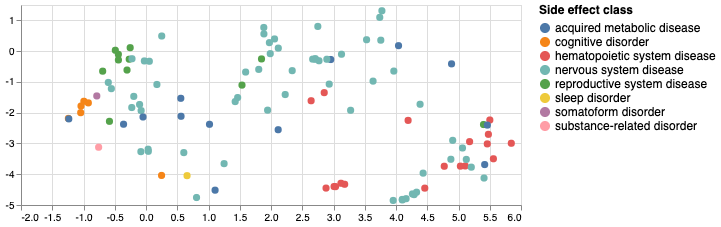

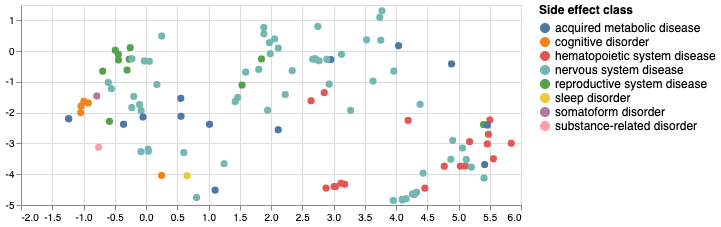

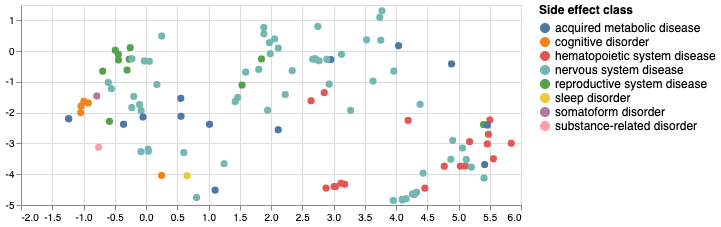

In [84]:
alt.Chart(data=points_df).mark_circle(size=50, opacity=1).encode(
    alt.X("x:Q", title=""),
    alt.Y("y:Q", title=""),
    alt.Color('group:N', title="Side effect class", scale=alt.Scale()),
    alt.Tooltip('side_effect:N')
).transform_filter(
    alt.FieldOneOfPredicate(field='group', oneOf=groups)
).properties(width=500, height=200).configure_legend(labelFontSize=12,labelLimit=250,titleFontSize=12)

### All

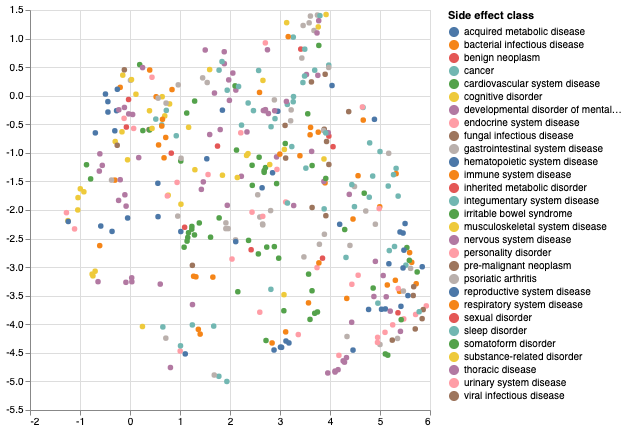

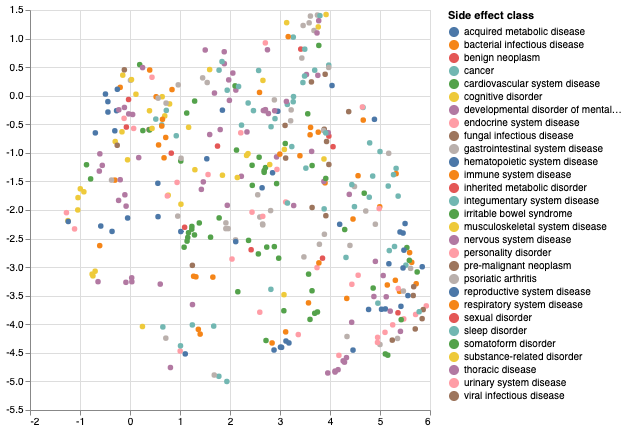

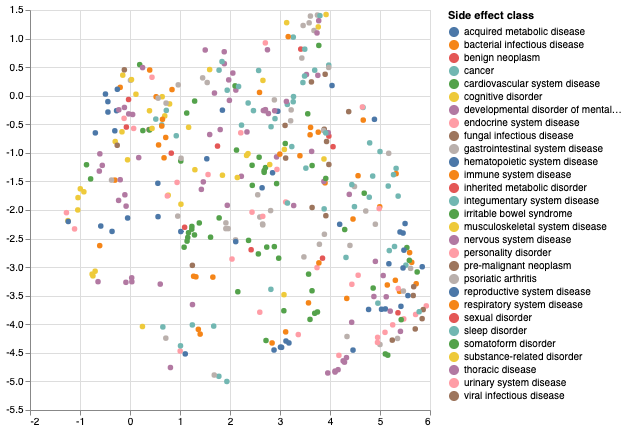

In [85]:
alt.Chart(data=points_df[points_df.group!='other']).mark_circle(opacity=1).encode(
    alt.X("x:Q",title=None),
    alt.Y("y:Q",title=None),
    alt.Color('group:N', title="Side effect class"),
    alt.Tooltip('side_effect:N')
).properties(width=400, height=400)

## Searching for familiar concepts

In [319]:
%%bash
cd ../outputs/

java -cp ../zenodo/semanticvectors-5.9.jar pitt.search.semanticvectors.Search -queryvectorfile predicatevectors.bin -matchcase KIDNEY_FAILURE 

1.000000:KIDNEY_FAILURE
0.958250:KIDNEY_FAILURE-2-INV
0.904125:ACUTE_KIDNEY_FAILURE
0.902125:ACUTE_KIDNEY_FAILURE-2-INV
0.872875:CARDIAC_FAILURE-2-INV
0.872000:ANAEMIA-2-INV
0.871125:ANAEMIA
0.869750:CARDIAC_FAILURE
0.869250:BLEEDING-2-INV
0.868875:SEPSIS-2-INV
0.866125:SEPSIS
0.865875:ASPARTATE_AMINOTRANSFERASE_INCREASE
0.864875:HEPATIC_FAILURE-2-INV
0.864875:BLEEDING
0.863000:ASYSTOLE-2-INV
0.862875:HEPATIC_FAILURE
0.861500:CARDIOVASCULAR_COLLAPSE-2-INV
0.860750:EXCESS_POTASSIUM-2-INV
0.859875:ICTERUS-2-INV
0.859750:ASPARTATE_AMINOTRANSFERASE_INCREASE-2-INV


Opening query vector store from file: predicatevectors.bin
Setting dimension of target config to: 16000
Setting vectortype of target config to: BINARY
Searching term vectors, searchtype SUM
Found vector for 'KIDNEY_FAILURE'
Search output follows ...


In [313]:
%%bash
cd ../outputs

java -cp ../zenodo/semanticvectors-5.9.jar pitt.search.semanticvectors.Search -elementalpredicatevectorfile predicatevectors.bin -semanticvectorfile semanticvectors.bin -elementalvectorfile elementalvectors.bin -matchcase -searchtype boundproduct -searchvectorfile predicatevectors.bin "S(aspirin)*E(warfarin)" 

0.362750:FIBROSING_ALVEOLITIS
0.347375:PAROTITIS
0.346000:FIBROSING_ALVEOLITIS-2-INV
0.343125:GOUTY_ARTHRITIS-2-INV
0.340750:HAEMARTHROSIS
0.339125:NECK_MASS
0.338875:PAROTITIS-2-INV
0.336125:HERNIA_INGUINAL
0.335750:NECK_MASS-2-INV
0.335250:MPD
0.332125:THROMBOPHLEBITIS-2-INV
0.331750:LUNG_ADENOCARCINOMA
0.331625:CUTANEOUS_MYCOSIS
0.330875:CUTANEOUS_MYCOSIS-2-INV
0.329000:HAEMARTHROSIS-2-INV
0.328625:BREAST_ENLARGEMENT-2-INV
0.328375:ARTHRITIS_BACTERIAL
0.328250:PLATELET_DISORDER
0.326375:MPD-2-INV
0.325875:IRRITATION_SKIN-2-INV


Opening query vector store from file: termvectors
Setting dimension of target config to: 16000
Setting vectortype of target config to: BINARY
Opening elemental query vector store from file: elementalvectors.bin
Opening semantic query vector store from file: semanticvectors.bin
Opening predicate query vector store from file: predicatevectors.bin
Opening search vector store from file: predicatevectors.bin
Searching term vectors, searchtype BOUNDPRODUCT
Found vector for 'aspirin'
Found vector for 'warfarin'
Search output follows ...


# Decagon evaluation
The scores here were produced with our own version of the Decagon code, available in the companion repository at https://github.com/hannahburkhardt/decagon. The model was trained for 8 epochs, which was not enough to achieve convergence. The scores here are provided for reference and do not reflect the best possible Decagon performance.

In [233]:
file_location = "../zenodo/"
decagon_scores = pd.read_csv(
    file_location + "decagon_scores_8_epochs.txt", sep="\t")
decagon_scores.columns = ["subject_name",
                          "predicate_name", "object_name", "result", "truth"]
print(decagon_scores.dtypes)
decagon_scores.head()

subject_name       object
predicate_name     object
object_name        object
result            float64
truth             float64
dtype: object


,subject_name,predicate_name,object_name,result,truth
0,CID000002244,C0004144,CID000003365,0.860732,1.0
1,CID000003440,C0004144,CID000004691,0.625638,1.0
2,CID000003957,C0004144,CID000004075,0.691289,1.0
3,CID000004168,C0004144,CID000005090,0.589250,1.0
4,CID000001117,C0004144,CID000077993,0.268906,1.0


In [234]:
[len(decagon_scores), len(
    decagon_scores[~decagon_scores.predicate_name.str.contains("_2")])]

[1828784, 914392]

In [235]:
decagon_scores = decagon_scores[~decagon_scores.predicate_name.str.contains(
    "_2")]
positive_decagon_scores = decagon_scores[decagon_scores.truth == 1]
negative_decagon_scores = decagon_scores[decagon_scores.truth == 0]

positive_examples = positive_decagon_scores[[
    'subject_name', 'predicate_name', 'object_name']]
pos_scores = positive_decagon_scores[['result']]
pos_scores.columns = [0]

negative_examples = negative_decagon_scores[[
    'subject_name', 'predicate_name', 'object_name']]
neg_scores = negative_decagon_scores[['result']]
neg_scores.columns = [0]

[len(positive_examples), len(negative_examples)]

[457196, 457196]

In [236]:
len(decagon_scores.predicate_name.unique())

963

Positive results mean score: 0.651
Negative results mean score: 0.198
Overall AUROC: 0.881
Overall AUPRC: 0.813
Overall AP50: 0.526

Average performance over 963 side effects:
       median   mean    std    sem    min    max
auroc   0.876  0.855  0.073  0.002  0.259  0.949
auprc   0.810  0.793  0.067  0.002  0.366  0.934
ap50    0.648  0.638  0.126  0.004  0.066  0.950


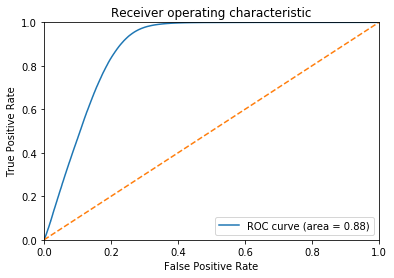

In [237]:
decagon_aurocs_by_se = esp_ddi_util.get_aurocs_by_side_effect(
    negative_examples=negative_examples, positive_examples=positive_examples, negative_results=neg_scores, positive_results=pos_scores)

In [238]:
for c in ['auroc', 'auprc', 'ap50']:
    print(c)
    print('min:', side_effect_names[decagon_aurocs_by_se[c].idxmin()], round(decagon_aurocs_by_se[c].min(
    ), 3), 'max:', side_effect_names[decagon_aurocs_by_se[c].idxmax()], round(decagon_aurocs_by_se[c].max(), 3))
    print()

auroc
min: HYPERMETROPIA 0.259 max: GASTRIC_ULCER_PERFORATED 0.949

auprc
min: HYPERMETROPIA 0.366 max: GALACTORRHEA 0.934

ap50
min: HYPERMETROPIA 0.066 max: SYNCOPE_VASOVAGAL 0.95



In [314]:
side_effect_names

{'C0151714': 'HYPERMAGNESEMIA',
 'C0035344': 'RETINOPATHY_OF_PREMATURITY',
 'C0004144': 'ATELECTASIS',
 'C0002063': 'ALKALOSIS',
 'C0004604': 'BACK_ACHE',
 'C0034063': 'LUNG_EDEMA',
 'C0085631': 'AGITATED',
 'C0013384': 'ABNORMAL_MOVEMENTS',
 'C0001122': 'ACIDOSIS',
 'C0034150': 'PELIOSIS',
 'C0038000': 'RUPTURE_OF_SPLEEN',
 'C0003578': 'APNEA',
 'C0013182': 'DRUG_HYPERSENSITIVITY',
 'C0016204': 'FLATULENCE',
 'C0242429': 'PAIN_IN_THROAT',
 'C0020517': 'ALLERGIES',
 'C0040034': 'THROMBOCYTOPENIA',
 'C0428977': 'BRADYCARDIA',
 'C0235896': 'LUNG_INFILTRATION',
 'C0019080': 'BLEEDING',
 'C0158986': 'HYPOGLYCAEMIA_NEONATAL',
 'C0236124': 'GASTROINTESTINAL_OBSTRUCTION',
 'C0020456': 'HYPERGLYCAEMIA',
 'C0031154': 'PERITONITIS',
 'C0020615': 'HYPOGLYCAEMIA',
 'C0000731': 'ABDOMINAL_DISTENSION',
 'C0018790': 'ASYSTOLE',
 'C0007785': 'CEREBRAL_INFARCT',
 'C0242184': 'HYPOXIA',
 'C0013404': 'DIFFICULTY_BREATHING',
 'C0020672': 'DECREASED_BODY_TEMPERATURE',
 'C0030446': 'ADYNAMIC_ILEUS',
 'C0243

### Performance distribution

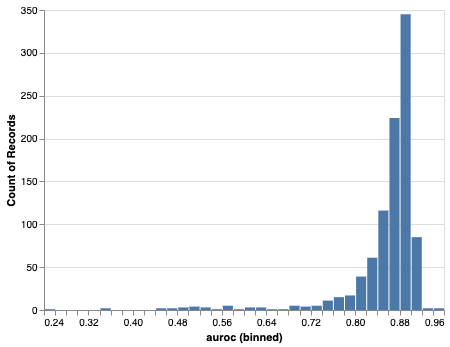

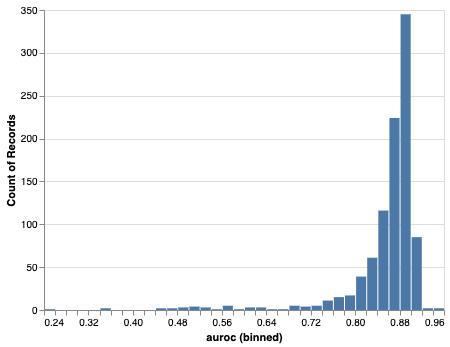

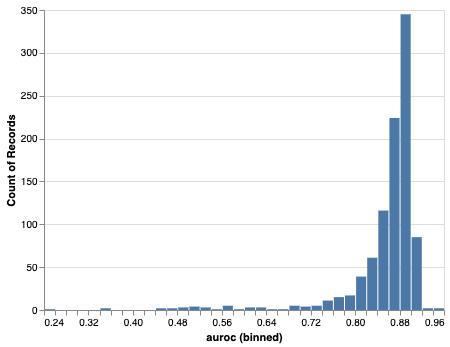

In [239]:
alt.Chart(decagon_aurocs_by_se).mark_bar().encode(
    x=alt.X(
        'auroc', 
        bin=alt.Bin(maxbins=50)
    ), 
    y='count()', 
    tooltip=[
        alt.Tooltip('count()')
    ]
)

### Performance by side effect frequency

In [240]:
df = decagon_aurocs_by_se.reset_index()
df.predicate_name = df.predicate_name.astype(
    'category').cat.rename_categories(side_effect_names)
df.head()
decagon_aurocs_by_se = df.set_index('predicate_name')

This chart shows that Decagon performs generally well on frequent side effects, while rarer side effects vary widely in performance, with some as low as 0.3.

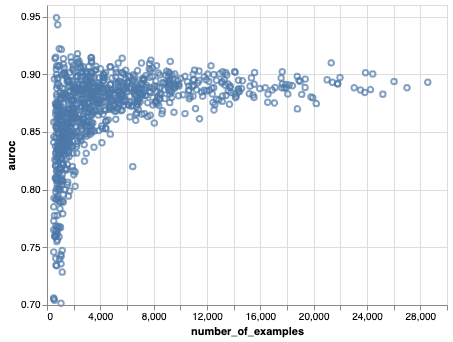

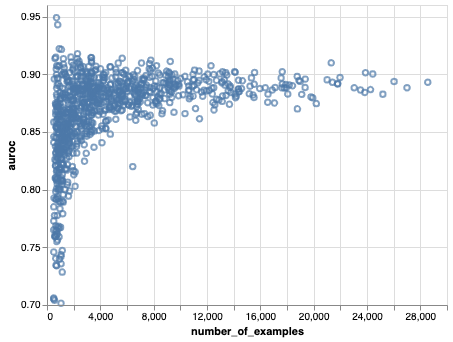

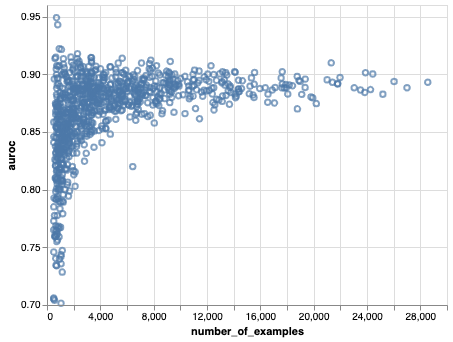

In [241]:
# the positive testing examples constitute 10% of the total number of samples in the dataset
alt.Chart(
    decagon_aurocs_by_se.reset_index()
).mark_point().encode(
    alt.Y(
        'auroc',
        scale=alt.Scale(zero=False)
    ),
    x='number_of_examples:Q',
    tooltip=['predicate_name', 'number_of_examples:Q']
).transform_calculate(
    number_of_examples=alt.datum.positive_examples*10
).transform_filter(alt.datum.auroc>0.7)

### Score distribution by label

In [242]:
pos_scores['truth'] = 1
neg_scores['truth'] = 0
scores = pos_scores.append(neg_scores)
scores.columns = ['score', 'truth']
scores.head()

/home/haalbu/anaconda3/envs/jupyter_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/haalbu/anaconda3/envs/jupyter_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,score,truth
0,0.860732,1
1,0.625638,1
2,0.691289,1
3,0.589250,1
4,0.268906,1


Here we can see that Decagon gives a large portion of the negatives very low scores (<0.1)!

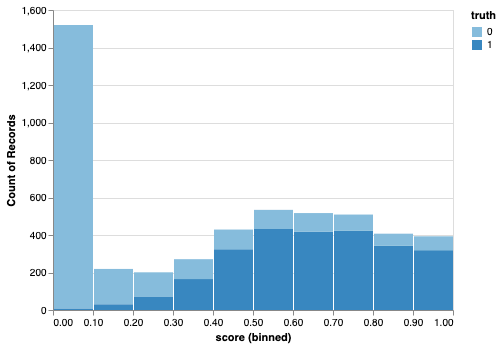

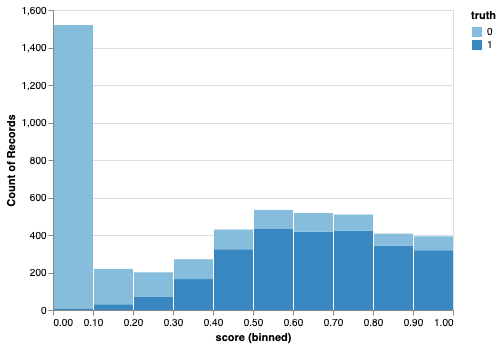

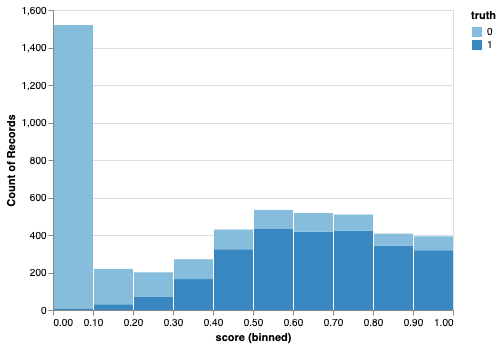

In [243]:
alt.Chart(scores.sample(5000)).mark_bar().encode(
    x=alt.X("score", bin=True), 
    y='count()', 
    color='truth:O'
)

# Comparison of best and worst side effects between ESP and Decagon

In [244]:
print("Best ESP side effects:")
pd.DataFrame(esp_aurocs_by_se[['auprc']].sort_values(
    by="auprc", ascending=False).auprc.apply(lambda x: ("%.3f" % x))).head(5)

Best ESP side effects:


,auprc
predicate_name,
MUMPS,0.976
ANAEMIA_HYPOCHROMIC,0.972
DYSHIDROSIS,0.971
CARCINOMA_OF_THE_CERVIX,0.970
FRACTURE_NONUNION,0.965


In [245]:
print("Worst ESP side effects:")
pd.DataFrame(esp_aurocs_by_se[['auprc']].sort_values(by="auprc",ascending=True).auprc.apply(lambda x: ("%.3f"%x))).head(5)

Worst ESP side effects:


,auprc
predicate_name,
CAESAREAN_SECTION,0.779
INTERSTITIAL_NEPHRITIS,0.790
MOUTH_BLEEDING,0.790
BRONCHIOLITIS,0.794
EMESIS,0.798


Compare to Decagon's reported best and worst side effects

In [247]:
decagon_reported = pd.DataFrame({"MUMPS" : 0.964,
"BLEEDING" : 0.679,
"CARBUNCLE" : 0.949,
"BODY_TEMPERATURE_INCREASED" : 0.680,
"COCCYDYNIA" : 0.943,
"EMESIS" : 0.693,
"TYMPANIC_MEMBRANE_PERFORATION" : 0.941,
"DISORDER_RENAL" : 0.694,
"DYSHIDROSIS" : 0.938,
"LEUCOPENIA" : 0.695,
"SPONDYLOSIS" : 0.929,
"DIARRHEA" : 0.705,
"SCHIZOAFFECTIVE_DISORDER" : 0.919,
"ICTERUS" : 0.707,
"BREAST_DYSPLASIA" : 0.918,
"NAUSEA" : 0.711,
"GANGLION" : 0.909,
"ITCH" : 0.712,
"UTERINE_POLYP" : 0.908,
"ANAEMIA" : 0.712}, index=['decagon_reported_auprc']).transpose()
decagon_reported.head()

,decagon_reported_auprc
MUMPS,0.964
BLEEDING,0.679
CARBUNCLE,0.949
BODY_TEMPERATURE_INCREASED,0.680
COCCYDYNIA,0.943


In [272]:
best_and_worst = decagon_reported.merge(esp_aurocs_by_se.auprc.rename(
    'esp_auprc'), how='left', left_index=True, right_index=True)
best_and_worst.sort_values(by='decagon_reported_auprc', ascending=False).round(3)

,decagon_reported_auprc,esp_auprc
MUMPS,0.964,0.976
CARBUNCLE,0.949,0.924
COCCYDYNIA,0.943,0.930
TYMPANIC_MEMBRANE_PERFORATION,0.941,0.929
DYSHIDROSIS,0.938,0.971
SPONDYLOSIS,0.929,0.940
SCHIZOAFFECTIVE_DISORDER,0.919,0.946
BREAST_DYSPLASIA,0.918,0.909
GANGLION,0.909,0.946
UTERINE_POLYP,0.908,0.903


This chart shows that the best performing side effects for Decagon and ESP are in the similar general region; however, ESP performs much better on side effects that Decagon models poorly.

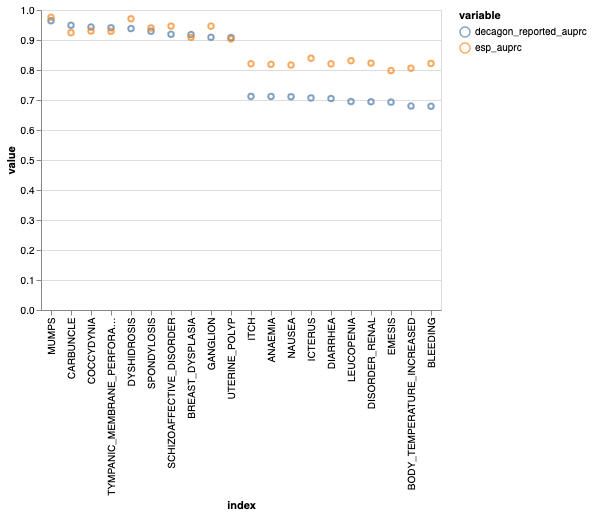

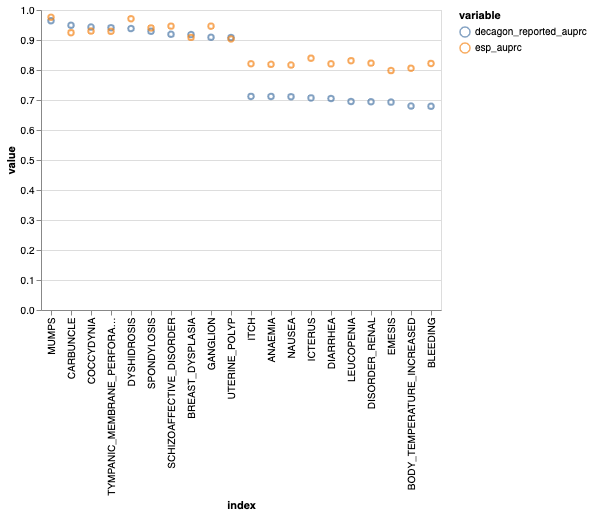

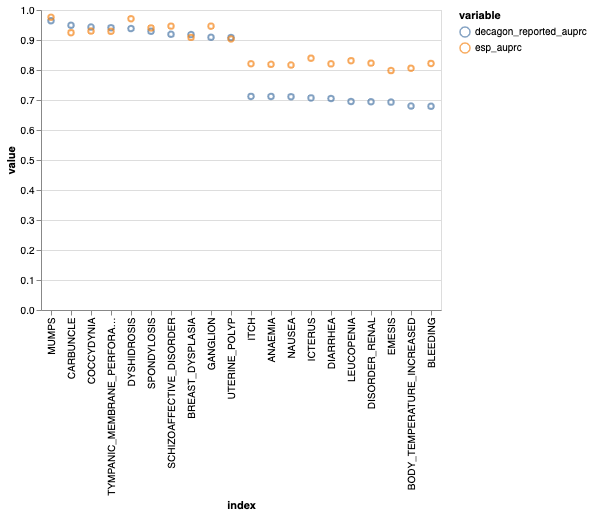

In [274]:
alt.Chart(
    best_and_worst.reset_index().melt(id_vars='index')
).mark_point(
).encode(
    x=alt.X('index', sort=decagon_reported.sort_values(
        by='decagon_reported_auprc', ascending=False).index.tolist()),
    y='value',
    color='variable'
)